In [1]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve()
if (REPO_ROOT / "src").exists() is False:
    # If you opened the notebook from inside /notebooks
    REPO_ROOT = REPO_ROOT.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [2]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
FIG_DIR = REPO_ROOT / "outputs" / "figures"
TAB_DIR = REPO_ROOT / "outputs" / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Robust repo root detection:
# Start from this notebook file location and go up until we find src/
HERE = Path.cwd().resolve()

# If you're running from notebooks/, repo root is one level up
candidates = [HERE, HERE.parent, HERE.parent.parent]

REPO_ROOT = None
for c in candidates:
    if (c / "src").exists():
        REPO_ROOT = c
        break

if REPO_ROOT is None:
    raise RuntimeError(f"Could not find repo root from {HERE}. Expected a folder containing /src.")

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("Working dir:", HERE)
print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])

from src.config import base_case
from src.model import run_deterministic_unit_econ, result_to_dict

Working dir: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\notebooks
Repo root: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim
sys.path[0]: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim


In [4]:
def truncated_normal(
    n: int,
    mean: float,
    sd: float,
    low: float,
    high: float,
    rng: np.random.Generator
) -> np.ndarray:
    """
    Draw samples from a truncated normal using rejection sampling.
    Fine for n=20k–50k without scipy.
    """
    out = np.empty(n, dtype=float)
    filled = 0
    while filled < n:
        draw = rng.normal(mean, sd, size=(n - filled) * 3)
        draw = draw[(draw >= low) & (draw <= high)]
        take = min(len(draw), n - filled)
        out[filled:filled + take] = draw[:take]
        filled += take
    return out


# --- Simulation setup ---
N = 20000
rng = np.random.default_rng(42)

base = base_case()

# Robustly fetch default rate name (handles config variations)
base_default = float(getattr(base, "default_rate", getattr(base, "annual_default_rate")))

# --- Distributions ---
# Default rate: bounded, skew-ish in reality, but truncated normal is fine to start.
default_rate_draws = truncated_normal(
    n=N,
    mean=base_default,
    sd=0.015,   # 1.5 percentage point std dev
    low=0.01,
    high=0.25,
    rng=rng
)

# CAC: positive and can have fat tails; truncated normal is OK for now.
cac_draws = truncated_normal(
    n=N,
    mean=float(base.cac_per_account),
    sd=40.0,
    low=50.0,
    high=600.0,
    rng=rng
)

# Funding cost: bounded; 1pp vol is reasonable.
funding_cost_draws = truncated_normal(
    n=N,
    mean=float(base.funding_cost_rate),
    sd=0.01,
    low=0.00,
    high=0.25,
    rng=rng
)

print("Draws created:")
print(f"default_rate: mean={default_rate_draws.mean():.4f}  min={default_rate_draws.min():.4f}  max={default_rate_draws.max():.4f}")
print(f"cac:          mean={cac_draws.mean():.2f}   min={cac_draws.min():.2f}   max={cac_draws.max():.2f}")
print(f"funding_cost: mean={funding_cost_draws.mean():.4f}  min={funding_cost_draws.min():.4f}  max={funding_cost_draws.max():.4f}")

Draws created:
default_rate: mean=0.0601  min=0.0111  max=0.1223
cac:          mean=249.82   min=94.47   max=411.13
funding_cost: mean=0.0600  min=0.0118  max=0.1059


In [5]:
# Decide which field name to update for defaults
default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"
print("Using default field:", default_field)

profits = np.empty(N, dtype=float)

for i in range(N):
    a = base.model_copy(update={
        default_field: float(default_rate_draws[i]),
        "cac_per_account": float(cac_draws[i]),
        "funding_cost_rate": float(funding_cost_draws[i]),
    })
    d = result_to_dict(run_deterministic_unit_econ(a))
    profits[i] = d["contribution_profit"]

sim_df = pd.DataFrame({
    "profit": profits,
    "default_rate": default_rate_draws,
    "cac_per_account": cac_draws,
    "funding_cost_rate": funding_cost_draws,
})

sim_df.head()

Using default field: annual_default_rate


,profit,default_rate,cac_per_account,funding_cost_rate
0,-3.166957e+06,0.064571,281.306882,0.071288
1,1.666199e+05,0.044400,237.548790,0.052262
2,-3.437466e+06,0.071257,311.106808,0.056861
3,-1.590363e+06,0.074108,209.629299,0.056549
4,2.527091e+06,0.030734,182.766118,0.046658


In [6]:
profit = sim_df["profit"].to_numpy()

expected_profit = float(profit.mean())
prob_loss = float((profit < 0).mean())
var_5 = float(np.quantile(profit, 0.05))
es_5 = float(profit[profit <= var_5].mean())

print(f"Expected profit: ${expected_profit:,.0f}")
print(f"Probability of loss: {prob_loss:.1%}")
print(f"VaR (5%): ${var_5:,.0f}")
print(f"Expected Shortfall (5%): ${es_5:,.0f}")

Expected profit: $-1,604,709
Probability of loss: 86.7%
VaR (5%): $-3,949,445
Expected Shortfall (5%): $-4,569,268


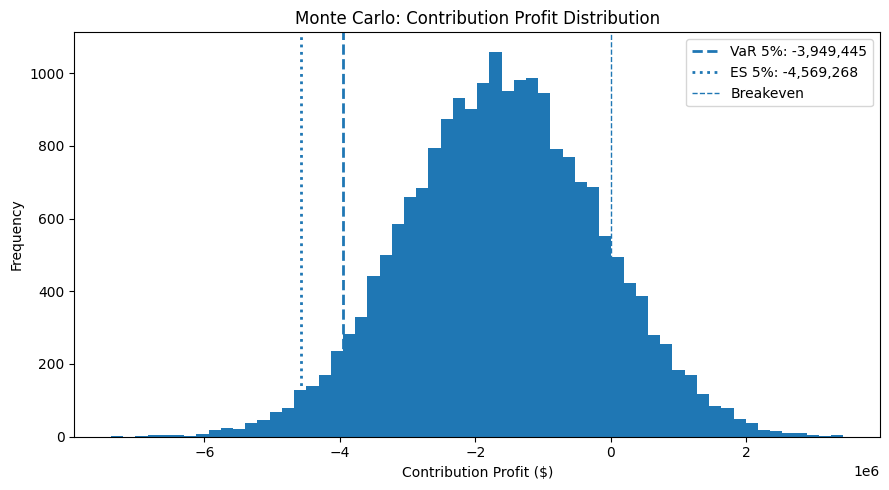

Saved: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\outputs\figures\profit_distribution_var_es_2026-02-25_2149.png


In [7]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
figs_dir = REPO_ROOT / "outputs" / "figures"
figs_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(9,5))
plt.hist(profit, bins=60)
plt.axvline(var_5, linestyle="--", linewidth=2, label=f"VaR 5%: {var_5:,.0f}")
plt.axvline(es_5, linestyle=":", linewidth=2, label=f"ES 5%: {es_5:,.0f}")
plt.axvline(0, linestyle="--", linewidth=1, label="Breakeven")

plt.title("Monte Carlo: Contribution Profit Distribution")
plt.xlabel("Contribution Profit ($)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

path = figs_dir / f"profit_distribution_var_es_{timestamp}.png"
plt.savefig(path, dpi=200)
plt.show()

print("Saved:", path)

In [8]:
def rankdata(x: np.ndarray) -> np.ndarray:
    return pd.Series(x).rank(method="average").to_numpy()

y = rankdata(sim_df["profit"].to_numpy())

drivers = ["default_rate", "cac_per_account", "funding_cost_rate"]
corrs = {}

for col in drivers:
    x = rankdata(sim_df[col].to_numpy())
    corrs[col] = float(np.corrcoef(x, y)[0, 1])

pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)

default_rate        -0.719301
cac_per_account     -0.533752
funding_cost_rate   -0.379507
dtype: float64